In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm

In [2]:
def pdf(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

In [3]:
from scipy.integrate import simpson

def compute_analytic_JSD(mean1, var1, mean2, var2):
    xmin = min(mean1 - 5 * np.sqrt(var1), mean2 - 5 * np.sqrt(var2))
    xmax = max(mean1 + 5 * np.sqrt(var1), mean2 + 5 * np.sqrt(var2))
    x_grid = np.linspace(xmin, xmax, 1000000)
    pdf1 = pdf(x_grid, mean1, var1)
    pdf2 = pdf(x_grid, mean2, var2)
    kl1 = simpson(y=(pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x=x_grid)
    kl2 = simpson(y=(pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x=x_grid)
    return 0.5 * (kl1 + kl2)

def generate_data(mean, var, N):
    return np.random.normal(mean, np.sqrt(var), N)

In [4]:
def compute_JSD(result1, result2, interpolation='quadratic', binning="FD"):    
    if binning == "FD":
        number_of_bins_1 = int((result1.max() - result1.min())/(2*iqr(result1)*result1.size**(-1/3)))
    elif binning == "S":
        number_of_bins_1 = int(1 + np.log2(result1.size))
    elif binning == "fuckit50":
        number_of_bins_1 = 50
    if number_of_bins_1 < 5:
        number_of_bins_1 = 5
    nbins1 = np.linspace(result1.min(), result1.max(), number_of_bins_1)

    if binning == "FD":
        number_of_bins_2 = int((result2.max() - result2.min())/(2*iqr(result2)*result2.size**(-1/3)))
    elif binning == "S":
        number_of_bins_2 = int(1 + np.log2(result2.size))
    elif binning == "fuckit50":
        number_of_bins_2 = 50
    if number_of_bins_2 < 5:
        number_of_bins_2 = 5
    nbins2 = np.linspace(result2.min(), result2.max(), number_of_bins_2)
    h, bins = np.histogram(
        result1, density=True, bins=nbins1
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])

    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)

    h, bins = np.histogram(
        result2, density=True, bins=nbins2
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)
    x_grid = np.linspace(min(min1, min2), max(max1, max2), 1000)

    def fit_1(x):
        return max(1e-10, fit1(x))

    def fit_2(x):
        return max(1e-10, fit2(x))


    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)

    JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid))**2
    return JSD, fit_1, fit_2

In [5]:
mean_1, var_1 = 0., 1.
mean_2, var_2 = 0., 1.6
N = 5000
data_1 = generate_data(mean_1, var_1, N)
data_2 = generate_data(mean_2, var_2, N)
analytic_JSD = compute_analytic_JSD(mean_1, var_1, mean_2, var_2)
print(analytic_JSD)
N_samples = 1000
standard_JSDs = []
for i in tqdm(range(N_samples)):
    data_1 = generate_data(mean_1, var_1, N)
    data_2 = generate_data(mean_2, var_2, N)
    JSD, fit_1, fit_2 = compute_JSD(data_1, data_2)
    standard_JSDs.append(JSD)
standard_JSDs = np.array(standard_JSDs)

0.01320469084642174


100%|██████████| 1000/1000 [00:21<00:00, 45.74it/s]


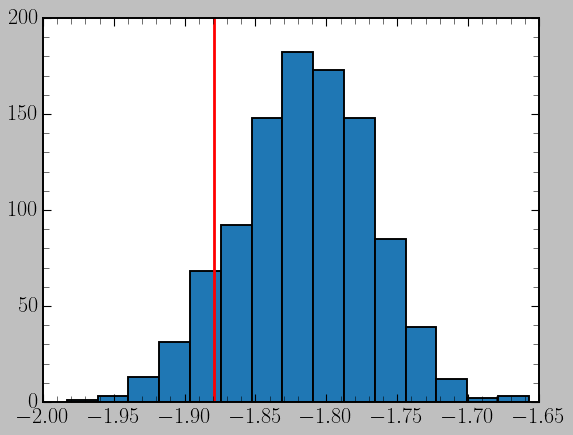

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(np.log10(standard_JSDs), bins=15)
plt.axvline(np.log10(analytic_JSD), color='r')
plt.show()

In [7]:
N = 10000
mean_1, var_1 = 0., 1.
mean_2, var_2 = 0., 4.
analytic_JSD = compute_analytic_JSD(mean_1, var_1, mean_2, var_2)
print(analytic_JSD)
data_1 = generate_data(mean_1, var_1, N)
data_2 = generate_data(mean_2, var_2, N)
baseline_JSD, fit_1, fit_2 = compute_JSD(data_1, data_2)

0.09273318297468366


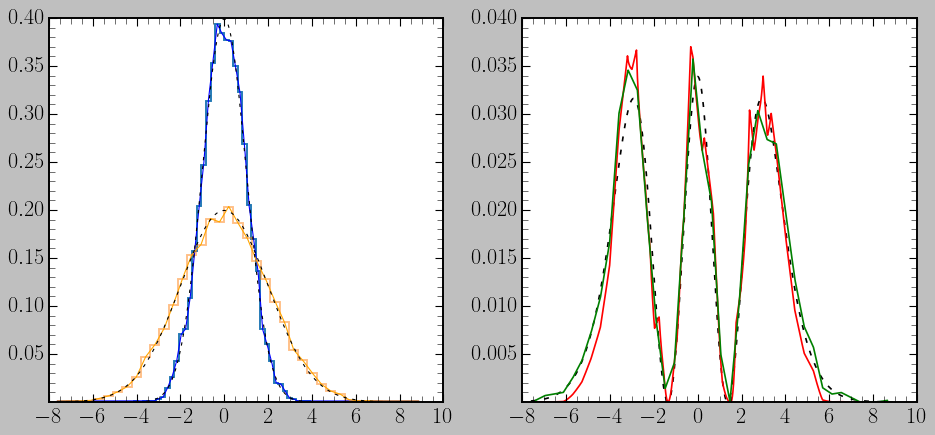

Analytic JSD:   0.09273318297468366
Baseline JSD:   0.09815212846545535
New JSD:        0.09535860084956618


100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


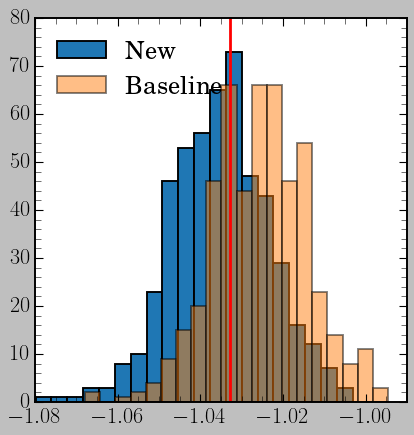

In [8]:
data_1 = generate_data(mean_1, var_1, N)
data_2 = generate_data(mean_2, var_2, N)
from scipy.stats import gaussian_kde
baseline_JSD, fit_1, fit_2 = compute_JSD(data_1, data_2)
def new_compute_JSD(result1, result2, interpolation='linear', binning="FI", nbins=40, plot=False):   
    if binning == "FD":
        number_of_bins_1 = int((result1.max() - result1.min())/(2*iqr(result1)*result1.size**(-1/3)))
    elif binning == "S":
        number_of_bins_1 = int(1 + np.log2(result1.size))
    elif binning == "FI":
        number_of_bins_1 = nbins
    if number_of_bins_1 < 5:
        number_of_bins_1 = 5
    
    if plot: plt.figure(figsize=(14, 6))
    if plot: ax = plt.subplot(1, 2, 1)
    nbins1 = np.linspace(result1.min(), result1.max(), number_of_bins_1)

    if binning == "FD":
        number_of_bins_2 = int((result2.max() - result2.min())/(2*iqr(result2)*result2.size**(-1/3)))
    elif binning == "S":
        number_of_bins_2 = int(1 + np.log2(result2.size))
    elif binning == "FI":
        number_of_bins_2 = nbins
    if number_of_bins_2 < 5:
        number_of_bins_2 = 5
    
    
    nbins2 = np.linspace(result2.min(), result2.max(), number_of_bins_2)
    h, bins = np.histogram(
        result1, density=True, bins=nbins1
    )
    if plot: plt.hist(data_1, bins=bins, density=True, histtype='step')
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])

    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)

    h, bins = np.histogram(
        result2, density=True, bins=nbins2
    )
    if plot: plt.hist(data_2, bins=bins, alpha=0.5, density=True, histtype='step')
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)
    xmin = min(result1.min(), result2.min())
    xmax = max(result1.max(), result2.max())
    x_grid = np.linspace(xmin, xmax, 10000)
    
    results = np.concatenate([result1, result2])
    number_of_bins = int((results.max() - results.min())/(2*iqr(results)*results.size**(-1/3))) // 2
    number_of_bins = 2 * int(1 + np.log2(results.size))
    x_bins = np.linspace(min(result1.min(), result2.min()), max(result1.max(), result2.max()), nbins)
    x_bin_centres = 0.5 * (x_bins[1:] + x_bins[0:-1])
    
    h1, _ = np.histogram(
        result1, density=True, bins=x_bins
    ) 

    h2, _ = np.histogram(
        result2, density=True, bins=x_bins
    )

    h1[h1 == 0] = 1e-200
    h2[h2 == 0] = 1e-200

    fitkl = interp1d(x_bin_centres, (h1 * (np.log(h1) - np.log(0.5 * (h1 + h2)))) + (h2 * (np.log(h2) - np.log(0.5 * (h1 + h2)))), kind=interpolation, fill_value=0.0, bounds_error=False)

    # kde_1 = gaussian_kde(result1)
    # kde_2 = gaussian_kde(result2)

    # def fit_1(x):
    #     return max(1e-10, kde_1(x))
    
    # def fit_2(x):
    #     return max(1e-10, kde_2(x))

    def fit_kl(x):
        return max(1e-100, fitkl(x))

    def fit_1(x):
        return max(1e-3, fit1(x))

    def fit_2(x):
        return max(1e-3, fit2(x))


    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)
    fit_kl = np.vectorize(fit_kl)

    if plot:
        plt.plot(x_grid, fit_1(x_grid), color='blue', lw=1.0)
        plt.plot(x_grid, fit_2(x_grid), color='orange', lw=1.0)
        f1, f2 = fit_1(x_grid), fit_2(x_grid)
        p1, p2 = pdf(x_grid, mean_1, var_1), pdf(x_grid, mean_2, var_2)
        plt.plot(x_grid, pdf(x_grid, mean_1, var_1), color='k', lw=1.0, ls='--')
        plt.plot(x_grid, pdf(x_grid, mean_2, var_2), color='k', lw=1.0, ls='--')
        plt.yscale('linear')
        plt.ylim(1e-6,)
        ax = plt.subplot(1, 2, 2)
        plt.plot(x_grid, (p1 * np.log(p1 / (0.5 * (p1 + p2)))) + (p2 * np.log(p2 / (0.5 * (p1 + p2)))), c='k', lw=1.5, ls='--')
        plt.plot(x_grid, (f1 * np.log(f1 / (0.5 * (f1 + f2)))) + (f2 * np.log(f2 / (0.5 * (f1 + f2)))), c='r', lw=1.5, ls='-')
        plt.plot(x_grid, fit_kl(x_grid), c='g', lw=1.5, ls='-')
        #plt.plot(x_bin_centres, (h1 * np.log(h1 / (0.5 * (h1 + h2)))) + (h2 * np.log(h2 / (0.5 * (h1 + h2)))))
        plt.yscale('linear')
        plt.ylim(1e-8,)
        plt.show()

    f1, f2 = fit_1(x_grid), fit_2(x_grid)
    #JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid))**2
    #return JSD
    # kl1 = simpson(y=(f1 * np.log(f1 / (0.5 * (f1 + f2)))), x=x_grid)
    # kl2 = simpson(y=(f2 * np.log(f2 / (0.5 * (f1 + f2)))), x=x_grid)
    # return 0.5 * (kl1 + kl2)
    return 0.5 * simpson(y=fit_kl(x_grid), x=x_grid)
    




JSD = new_compute_JSD(data_1, data_2, nbins=40, plot=True)
print("Analytic JSD:  ", analytic_JSD)
print("Baseline JSD:  ", baseline_JSD)
print("New JSD:       ", JSD)

N_samples = 500
JSDs = []
cJSDs = []
for i in tqdm(range(N_samples)):
    data_1 = generate_data(mean_1, var_1, N)
    data_2 = generate_data(mean_2, var_2, N)
    JSD = new_compute_JSD(data_1, data_2, nbins=40)
    JSDs.append(JSD)
    cJSD, _, _ = compute_JSD(data_1, data_2)
    cJSDs.append(cJSD)
JSDs = np.array(JSDs)
cJSDs = np.array(cJSDs)
plt.figure()
plt.hist(np.log10(JSDs), bins=20, label='New')
plt.hist(np.log10(cJSDs), bins=20, alpha=0.5, label='Baseline')
plt.axvline(np.log10(analytic_JSD), color='r')
plt.legend()
plt.show()

In [9]:
def fast_compute_JSD(result1, result2, interpolation='linear', nbins=40):   
    xmin = min(result1.min(), result2.min())
    xmax = max(result1.max(), result2.max())
    x_grid = np.linspace(xmin, xmax, 1000)
    
    x_bins = np.linspace(min(result1.min(), result2.min()), max(result1.max(), result2.max()), nbins)
    x_bin_centres = 0.5 * (x_bins[1:] + x_bins[0:-1])
    
    h1, _ = np.histogram(
        result1, density=True, bins=x_bins
    ) 

    h2, _ = np.histogram(
        result2, density=True, bins=x_bins
    )

    h1[h1 == 0] = 1e-200
    h2[h2 == 0] = 1e-200

    fitkl = interp1d(x_bin_centres, (h1 * (np.log(h1) - np.log(0.5 * (h1 + h2)))) + (h2 * (np.log(h2) - np.log(0.5 * (h1 + h2)))), kind=interpolation, fill_value=0.0, bounds_error=False)

    def fit_kl(x):
        return max(1e-100, fitkl(x))

    fit_kl = np.vectorize(fit_kl)
    return 0.5 * simpson(y=fit_kl(x_grid), x=x_grid)

In [49]:
N_arr = [500, 1000, 5000, 10000, 50000, 100000]
bins_arr = [15, 15, 25, 30, 30, 35]

In [50]:
for N, nbs in zip(N_arr, bins_arr):
    print(f"N = {N}, n_bins = {nbs}")
    N_samples = 200
    N_points = 50
    var_start = 2.0**2
    var_end = 1.001**2
    var_factor = np.exp(np.log(var_end/var_start)/(N_points-1))
    var_list = np.array([var_start*var_factor**i for i in range(N_points)])
    vtrue_jsds = np.zeros((N_points))
    vestimated_jsds = np.zeros((N_points, N_samples))
    for i, variance in tqdm(enumerate(var_list)):
        vtrue_jsd = compute_analytic_JSD(mean_1, 1.0, mean_2, variance)
        for j in range(N_samples):
            result1 = generate_data(mean_1, 1.0, N)
            result2 = generate_data(mean_2, variance, N)
            JSD = fast_compute_JSD(result1, result2, nbins=nbs)
            vestimated_jsds[i, j] = JSD
        vtrue_jsds[i] = vtrue_jsd
    np.save(f"/Users/james/Code/doppel/jsd/true_jsds_vars_N_{N}_nbins_{nbs}.npy", vtrue_jsds)
    np.save(f"/Users/james/Code/doppel/jsd/estimated_jsds_vars_N_{N}_nbins_{nbs}.npy", vestimated_jsds)

N = 500, n_bins = 15


50it [00:58,  1.18s/it]


N = 1000, n_bins = 15


50it [01:00,  1.20s/it]


N = 5000, n_bins = 25


50it [01:06,  1.34s/it]


N = 10000, n_bins = 30


50it [01:15,  1.51s/it]


N = 50000, n_bins = 30


50it [02:34,  3.08s/it]


N = 100000, n_bins = 35


50it [04:12,  5.05s/it]


Text(0.5, 1.0, 'N = 100000')

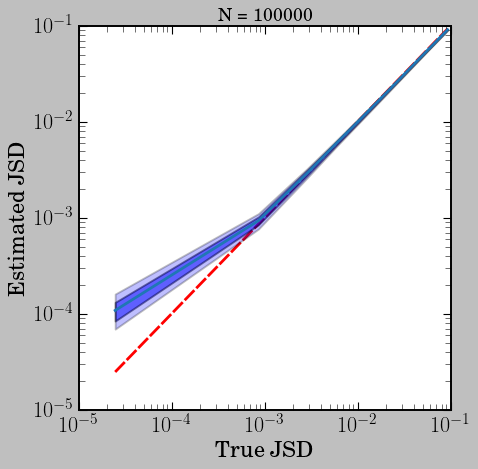

In [42]:
plt.plot(vtrue_jsds, np.quantile(vestimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(vtrue_jsds, vtrue_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(vtrue_jsds, np.quantile(vestimated_jsds, 0.16, axis=1), np.quantile(vestimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(vtrue_jsds, np.quantile(vestimated_jsds, 0.025, axis=1), np.quantile(vestimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-4, 1e-1)
# plt.ylim(1e-4, 1e-1)
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title(f'N = {N}')